# Setup

In [51]:
import sys
from IPython.display import display, HTML
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Check if GPU is enabled (for Colab users)
in_colab = "google.colab" in sys.modules
if in_colab:
  if torch.cuda.is_available():
      device_name = torch.cuda.get_device_name(0)
      print(f"✅ GPU detected: {device_name}")
  else:
      warning_html = """
      <div style="background-color:#fff3cd;border:1px solid #ffeeba;
                  padding:15px;border-radius:8px;">
          ⚠️ <b>No GPU detected.</b><br>
          To speed up model inference:
          <ol>
              <li>Click on <b>Runtime</b> (top menu)</li>
              <li>Select <b>Change runtime type</b></li>
              <li>Set <b>Hardware accelerator</b> to <b>GPU</b></li>
              <li>Then re-run this notebook.</li>
          </ol>

          Or, you can continue to the next cells but it will take a while running on CPU... up to you!
      </div>
      """
      display(HTML(warning_html))
      device = torch.device("cpu")
      raise RuntimeError(
          "⚠️ No GPU detected. Please change: Runtime > Change runtime type > GPU."
      )

✅ GPU detected: Tesla T4


In [3]:
if in_colab:
    # Clone GitHub repo and move into it
    !git clone https://github.com/championjeyson/agb-prediction.git
    %cd agb-prediction

    # Install dependencies
    !pip install -r requirements.txt

    # # Make sure src/ is importable
    # sys.path.append("src")

else:
    # Make sure src/ is importable
    sys.path.append("..")
    # sys.path.append("../src")

Cloning into 'agb-prediction'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 91 (delta 20), reused 72 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (91/91), 41.33 KiB | 705.00 KiB/s, done.
Resolving deltas: 100% (20/20), done.
Filtering content: 100% (18/18), 177.59 MiB | 67.00 MiB/s, done.
/content/agb-prediction
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━

In [93]:
from src.utils.config import *
from src.imagery_processing import (
    process_s2_data,
    process_alos_data,
    process_dem_data,
)
from src.models import (
    load_model_config,
    load_model_data_statistics,
)

# Parameters

In [55]:
longer_dim_figsize = 8

# Visualize some of the inputs

## Sentinel-2 Imagery

/usr/local/lib/python3.12/dist-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


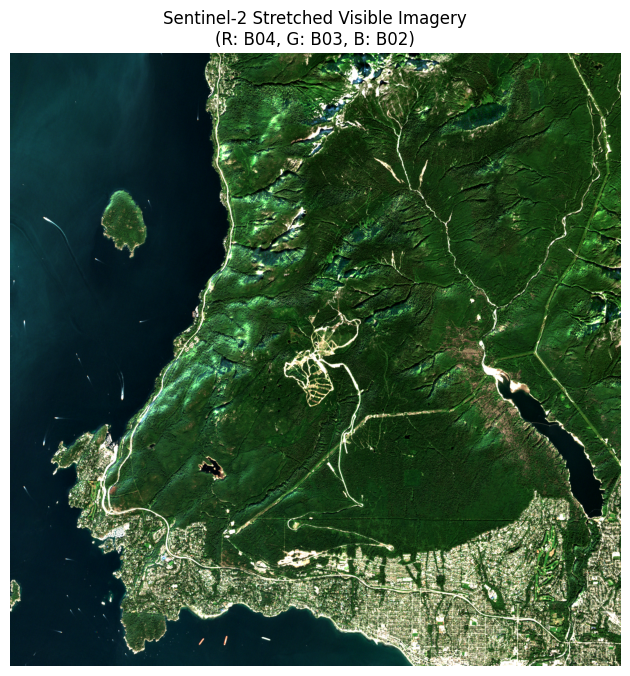

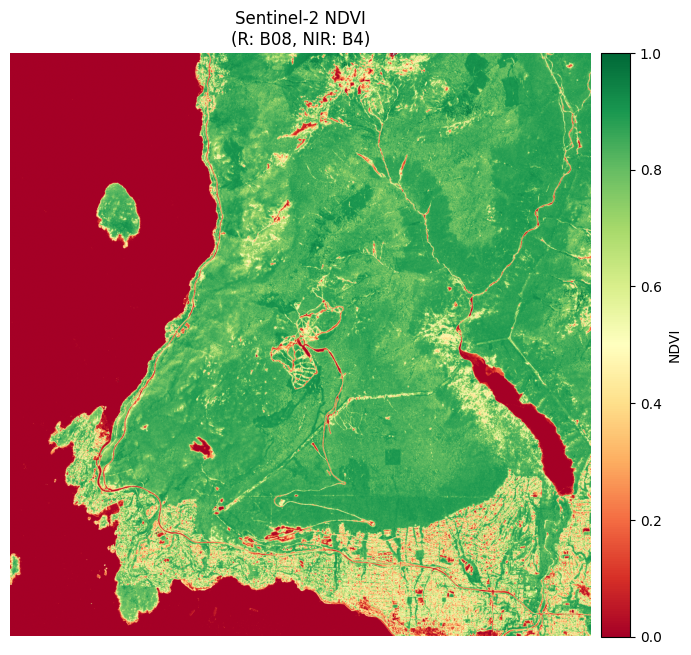

In [58]:
# Load config
CFG = get_config("default.yaml")

# Load model config and data statistics
model_cfg = load_model_config()
model_norm_values = load_model_data_statistics()

# Process Sentinel-2 data
dict_s2_processed_bands, _, xds_s2_ref_band, *_ = process_s2_data()

# Extract and display visible imagery (stretched)
s2_rgb = xr.concat([dict_s2_processed_bands['B04'], dict_s2_processed_bands['B03'], dict_s2_processed_bands['B02']], dim='band').transpose("y", "x", "band")
p2, p98 = np.percentile(s2_rgb, (2, 98))
s2_rgb_stretch = np.clip((s2_rgb - p2) / (p98 - p2), 0, 1)

figsize = (np.array(s2_rgb.shape[:2]))/max(s2_rgb.shape[:2]) * longer_dim_figsize

fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(s2_rgb_stretch)
ax.set_title("Sentinel-2 Stretched Visible Imagery\n(R: B04, G: B03, B: B02)")
ax.axis("off")

# Extract and display NDVI image
nir = dict_s2_processed_bands["B08"]
red = dict_s2_processed_bands["B04"]
s2_ndvi = (nir - red) / (nir + red)

fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(s2_ndvi, cmap="RdYlGn", vmin=0, vmax=1)
ax.set_title("Sentinel-2 NDVI\n(R: B08, NIR: B4)")
ax.axis("off")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = fig.colorbar(im, cax=cax)
cb.set_label("NDVI")

plt.show()

## ALOS/PALSAR Imagery

(np.float64(-0.5), np.float64(1506.5), np.float64(1513.5), np.float64(-0.5))

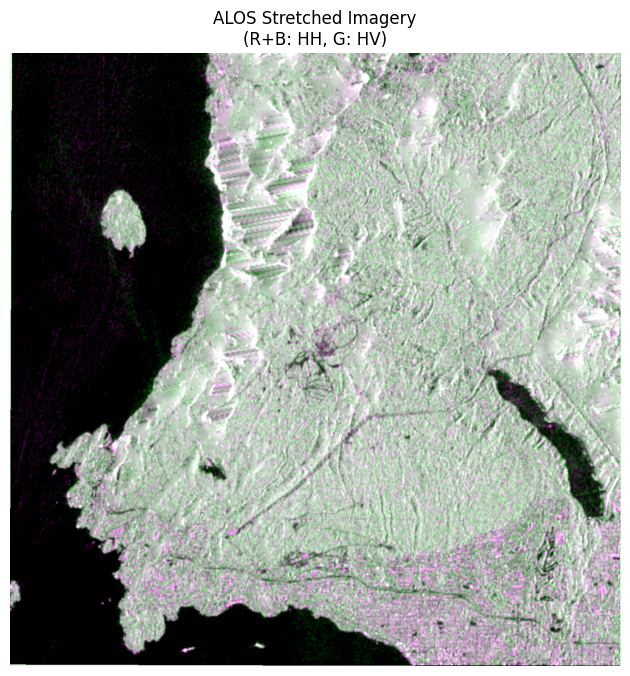

In [102]:
# Process ALOS data
xds_alos_gamma = process_alos_data(xds_s2_ref_band)

# Extract and display SAR imagery (stretched)
bands = ['HH', 'HV', 'HH']
da_list = [ xds_alos_gamma.sel(band=b) for b in bands ]
stretched_list = []
for da in da_list:
    # compute percentiles for this band only
    plow = np.nanpercentile(da, 20)
    p98 = np.nanpercentile(da, 98)
    stretched = (da - plow) / (p98 - plow)
    stretched = stretched.clip(0, 1)
    stretched_list.append(stretched)
xds_alos_gamma_rgb_stretch = xr.concat(stretched_list, dim='band').transpose("y", "x", "band")

figsize = (np.array(xds_alos_gamma_rgb_stretch.shape[:2]))/max(xds_alos_gamma_rgb_stretch.shape[:2]) * longer_dim_figsize

fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(xds_alos_gamma_rgb_stretch)
ax.set_title("ALOS Stretched Imagery\n(R+B: HH, G: HV)")
ax.axis("off")

## Digital Elevation Model (DEM)

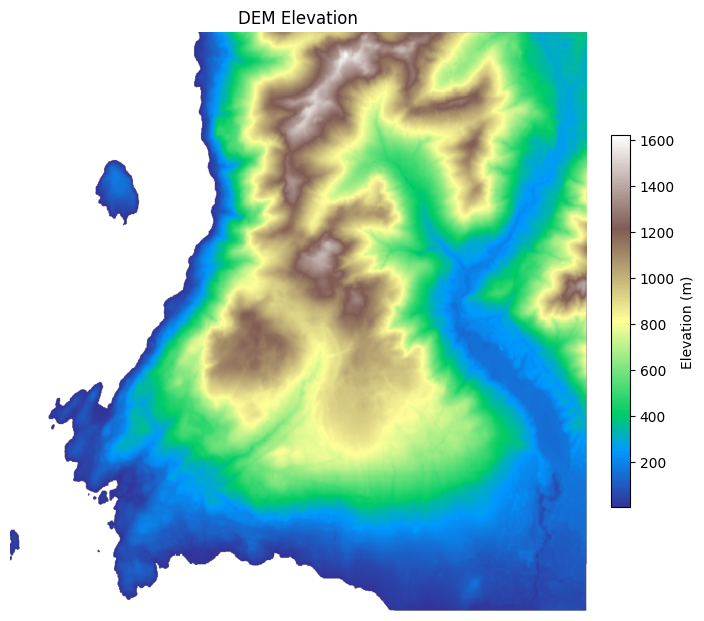

In [101]:
# Process DEM data
xds_dem = process_dem_data(xds_s2_ref_band)
xds_dem = xds_dem.where(xds_dem > 0, np.nan)

# Create figure
fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(xds_dem, cmap='terrain')
ax.set_title("DEM Elevation")
ax.axis("off")

# Add colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("Elevation (m)")

plt.show()

# Run inference on the example dataset

In [ ]:
from src.inference import run_inference
run_inference()

/content/agb-prediction/src/imagery_processing/__init__.py:114: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  xds_lc_encoded = xr.apply_ufunc(


Unfreeze last layer (mean regressor)... args.freeze_last_mean=False


Predicting patches: 100%|██████████| 100/100 [05:46<00:00,  3.46s/patch]


0